# Pizza I4 Architecture - Production Experiment Analysis
This notebook analyzes order and pizza production data to identify performance patterns and bottlenecks.

In [1]:
!pip install pandas numpy matplotlib seaborn scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Data Loading and Preparation

In [31]:
# Load data
order_df = pd.read_csv('experiment-data/order_latency.csv')
pizza_df = pd.read_csv('experiment-data/pizza_latency.csv')

print(f"Original Orders: {len(order_df)}")
print(f"Original Pizzas: {len(pizza_df)}")

# Convert timestamps
for df in [order_df, pizza_df]:
    df['START_TIME'] = pd.to_datetime(df['STARTTIMESTAMP'], unit='ms')
    df['END_TIME'] = pd.to_datetime(df['ENDTIMESTAMP'], unit='ms', errors='coerce')
    
# Calculate latency in seconds
order_df['LATENCY_S'] = (order_df['END_TIME'] - order_df['START_TIME']).dt.total_seconds()
pizza_df['LATENCY_S'] = (pizza_df['END_TIME'] - pizza_df['START_TIME']).dt.total_seconds()

# Separate completed and incomplete
completed_orders = order_df.dropna(subset=['END_TIME']).copy()
incomplete_orders = order_df[order_df['END_TIME'].isna()].copy()

completed_pizzas = pizza_df.dropna(subset=['END_TIME']).copy()
incomplete_pizzas = pizza_df[pizza_df['END_TIME'].isna()].copy()

print(f"\nCompleted Orders: {len(completed_orders)} ({len(completed_orders)/len(order_df)*100:.1f}%)")
print(f"Incomplete Orders: {len(incomplete_orders)} ({len(incomplete_orders)/len(order_df)*100:.1f}%)")
print(f"\nCompleted Pizzas: {len(completed_pizzas)} ({len(completed_pizzas)/len(pizza_df)*100:.1f}%)")
print(f"Incomplete Pizzas: {len(incomplete_pizzas)} ({len(incomplete_pizzas)/len(pizza_df)*100:.1f}%)")

Original Orders: 40
Original Pizzas: 1610

Completed Orders: 40 (100.0%)
Incomplete Orders: 0 (0.0%)

Completed Pizzas: 1610 (100.0%)
Incomplete Pizzas: 0 (0.0%)


## 2. Order-Level Analysis

In [32]:
# Summary statistics
print("ORDER LATENCY STATISTICS (Completed Orders Only)")
print(f"\nMean: {completed_orders['LATENCY_S'].mean():.2f}s")
print(f"Median: {completed_orders['LATENCY_S'].median():.2f}s")
print(f"Std Dev: {completed_orders['LATENCY_S'].std():.2f}s")
print(f"Min: {completed_orders['LATENCY_S'].min():.2f}s")
print(f"Max: {completed_orders['LATENCY_S'].max():.2f}s")

# Percentiles
percentiles = [25, 50, 75, 90, 95, 99]
print("\nPercentiles:")
for p in percentiles:
    val = np.percentile(completed_orders['LATENCY_S'], p)
    print(f"  P{p}: {val:.2f}s")

# Group by order size
size_analysis = completed_orders.groupby('ORDERSIZE').agg({
    'LATENCY_S': ['count', 'mean', 'median', 'std', 'min', 'max']
}).round(2)
size_analysis.columns = ['Count', 'Mean(s)', 'Median(s)', 'Std(s)', 'Min(s)', 'Max(s)']
display(size_analysis)

ORDER LATENCY STATISTICS (Completed Orders Only)

Mean: 141.74s
Median: 107.22s
Std Dev: 125.13s
Min: 16.43s
Max: 343.22s

Percentiles:
  P25: 37.91s
  P50: 107.22s
  P75: 212.31s
  P90: 329.60s
  P95: 336.72s
  P99: 341.02s


,Count,Mean(s),Median(s),Std(s),Min(s),Max(s)
ORDERSIZE,,,,,,
1,10,17.39,17.32,0.67,16.43,18.44
10,10,47.08,47.25,1.35,44.40,49.03
50,10,171.85,171.66,3.15,165.40,176.04
100,10,330.65,328.46,6.88,321.13,343.22


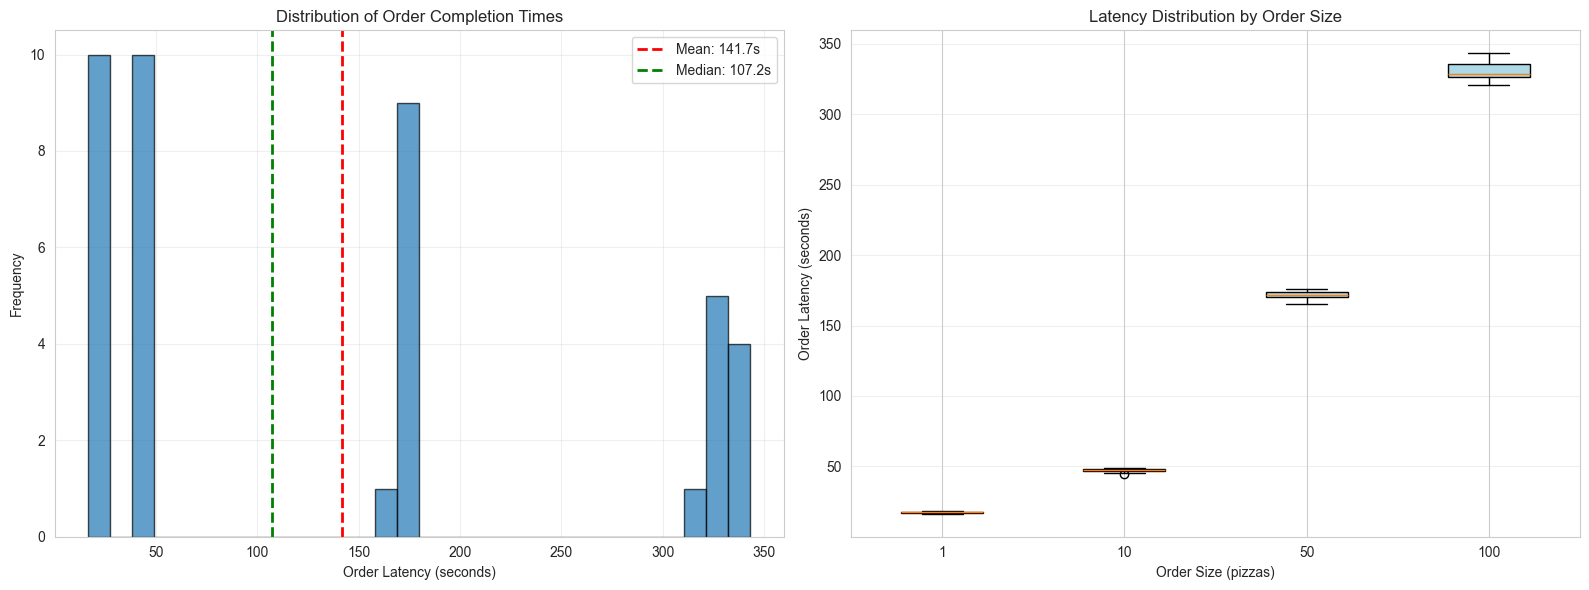

✓ Saved: order_analysis_comprehensive.png


In [33]:
# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Convert order size to string for plotting
completed_orders["ORDERSIZE"] = completed_orders["ORDERSIZE"].astype(str)
# Define ordered categorical
desired_order = ["1", "10", "50", "100"]
completed_orders["ORDERSIZE"] = pd.Categorical(
    completed_orders["ORDERSIZE"],
    categories=desired_order,
    ordered=True
)

# Sort dataframe by that ordered category
completed_orders = completed_orders.sort_values("ORDERSIZE")

# 1. Distribution of order latency
axes[0].hist(completed_orders['LATENCY_S'], bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(completed_orders['LATENCY_S'].mean(), color='red',
                   linestyle='--', linewidth=2, label=f'Mean: {completed_orders["LATENCY_S"].mean():.1f}s')
axes[0].axvline(completed_orders['LATENCY_S'].median(), color='green',
                   linestyle='--', linewidth=2, label=f'Median: {completed_orders["LATENCY_S"].median():.1f}s')
axes[0].set_xlabel('Order Latency (seconds)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Order Completion Times')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 3. Box plot by order size
# Sort sizes numerically, not alphabetically
order_sizes_sorted = sorted(
    completed_orders['ORDERSIZE'].unique(),
    key=lambda x: int(x)
)

# Prepare data for each box
data_for_box = [
    completed_orders[completed_orders['ORDERSIZE'] == size]['LATENCY_S']
    for size in order_sizes_sorted
]

bp = axes[1].boxplot(
    data_for_box,
    labels=order_sizes_sorted,
    patch_artist=True
)

for patch in bp['boxes']:
    patch.set_facecolor('lightblue')

axes[1].set_xlabel('Order Size (pizzas)')
axes[1].set_ylabel('Order Latency (seconds)')
axes[1].set_title('Latency Distribution by Order Size')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('order_analysis_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: order_analysis_comprehensive.png")

## 3. Pizza-Level Analysis

In [34]:
# Merge pizza data with order size
completed_pizzas['S_ORDER_ID'] = completed_pizzas['S_ORDER_ID'].astype(str)
pizza_enriched = completed_pizzas.merge(
    order_df[['ORDERID', 'ORDERSIZE']],
    left_on='S_ORDER_ID',
    right_on='ORDERID',
    how='left'
)

print("PIZZA LATENCY STATISTICS")
print(f"\nMean: {pizza_enriched['LATENCY_S'].mean():.2f}s")
print(f"Median: {pizza_enriched['LATENCY_S'].median():.2f}s")
print(f"Std Dev: {pizza_enriched['LATENCY_S'].std():.2f}s")
print(f"Min: {pizza_enriched['LATENCY_S'].min():.2f}s")
print(f"Max: {pizza_enriched['LATENCY_S'].max():.2f}s")

# Analysis by order size
print("PIZZA LATENCY BY ORDER SIZE")
pizza_by_size = pizza_enriched.groupby('ORDERSIZE').agg({
    'LATENCY_S': ['count', 'mean', 'median', 'std', 'min', 'max']
}).round(2)
pizza_by_size.columns = ['Count', 'Mean(s)', 'Median(s)', 'Std(s)', 'Min(s)', 'Max(s)']
display(pizza_by_size)

PIZZA LATENCY STATISTICS

Mean: 19.53s
Median: 18.87s
Std Dev: 3.17s
Min: 14.24s
Max: 30.31s
PIZZA LATENCY BY ORDER SIZE


,Count,Mean(s),Median(s),Std(s),Min(s),Max(s)
ORDERSIZE,,,,,,
1,10,17.39,17.32,0.67,16.43,18.44
10,100,19.12,19.41,1.51,15.71,22.24
50,500,19.31,18.88,2.74,14.92,28.66
100,1000,19.71,18.82,3.48,14.24,30.31


## 4. Order vs Pizza Comparison

In [38]:
# Compare total order time vs sum of pizza times
pizza_sum_by_order = pizza_enriched.groupby('S_ORDER_ID')['LATENCY_S'].sum().reset_index()
pizza_sum_by_order.columns = ['ORDERID', 'TOTAL_PIZZA_TIME']

comparison = completed_orders[['ORDERID', 'ORDERSIZE', 'LATENCY_S']].merge(
    pizza_sum_by_order, on='ORDERID', how='inner'
)
comparison['TIME_DIFFERENCE'] = comparison['LATENCY_S'] - comparison['TOTAL_PIZZA_TIME']
comparison['EFFICIENCY_RATIO'] = comparison['TOTAL_PIZZA_TIME'] / comparison['LATENCY_S']

print("ORDER EFFICIENCY ANALYSIS")
print("\nOrders where total pizza time < order time (parallel production):")
display(comparison[comparison['TIME_DIFFERENCE'] > 0][['ORDERID', 'ORDERSIZE', 'TIME_DIFFERENCE', 'EFFICIENCY_RATIO']])

print(f"\nAverage efficiency ratio: {comparison['EFFICIENCY_RATIO'].mean():.2f}")
print(f"(Ratio > 1 indicates sequential production, < 1 indicates parallel production)")

ORDER EFFICIENCY ANALYSIS

Orders where total pizza time < order time (parallel production):


,ORDERID,ORDERSIZE,TIME_DIFFERENCE,EFFICIENCY_RATIO
0,0d956eaa-5cc8-4320-b62c-3ca8249085af,1,0.001,0.999941
1,15f9a334-bffb-41bf-848c-49712061adb7,1,0.046,0.997461
2,21bbeb07-fbcc-4e06-9065-28505bcc24a4,1,0.004,0.999770
4,317a6e67-b057-405b-b312-ad8a45f36a89,1,0.001,0.999941
5,8af0bef9-0613-46c5-bf88-3b6c2be9450b,1,0.001,0.999946
7,67244438-f41b-4ebc-90f8-0cd7f9d837db,1,0.001,0.999943
8,62aae3dc-c73e-4bb7-88e4-7f070e6663db,1,0.001,0.999941
9,5e76c97b-3842-4ba0-b662-806ae2486e85,1,0.001,0.999945



Average efficiency ratio: 4.16
(Ratio > 1 indicates sequential production, < 1 indicates parallel production)


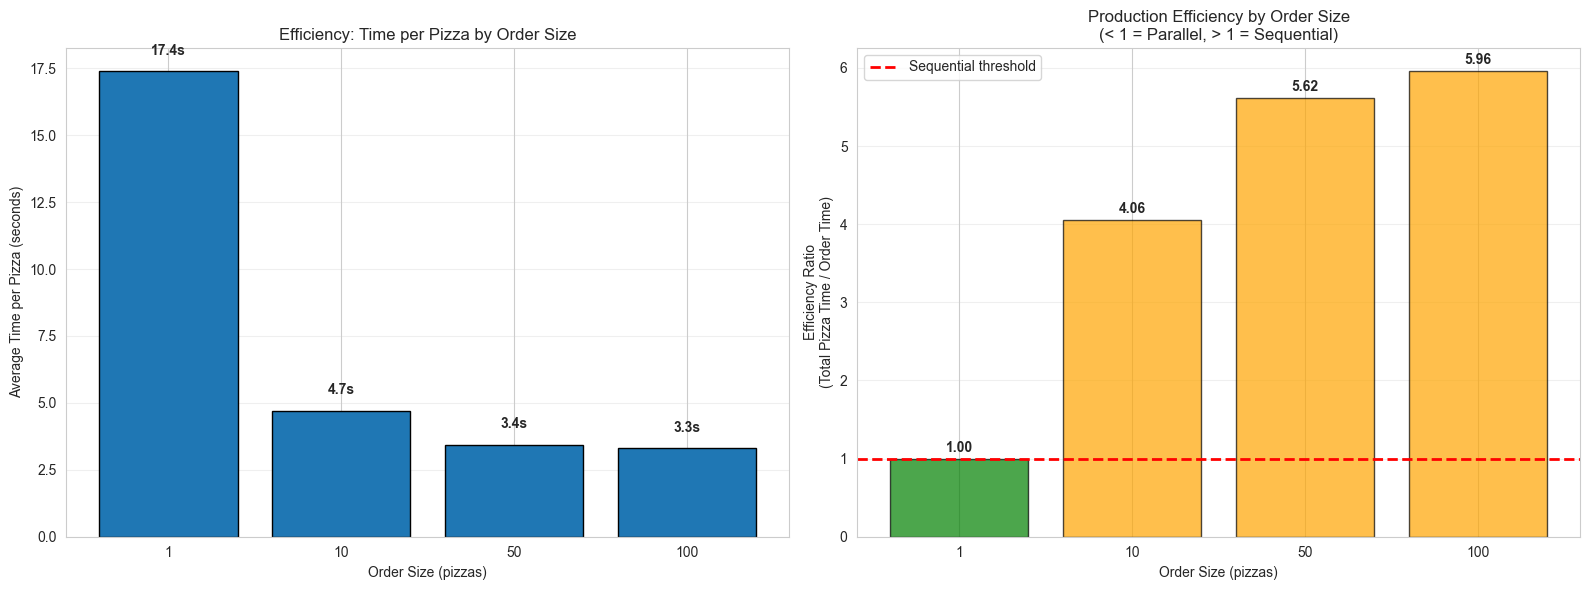

✓ Saved: order_pizza_comparison.png


In [39]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# Group in categorical order
efficiency_by_size = comparison.groupby('ORDERSIZE')['EFFICIENCY_RATIO'].mean()

# ---Average latency per pizza by order size---
# Numeric version for calculations
completed_orders["ORDERSIZE_NUM"] = completed_orders["ORDERSIZE"].astype(int)
# Compute time per pizza
completed_orders['LATENCY_PER_PIZZA'] = (
    completed_orders['LATENCY_S'] / completed_orders['ORDERSIZE_NUM']
)
# Sort order sizes numerically
order_sizes_sorted = sorted(
    completed_orders["ORDERSIZE"].unique(),
    key=lambda x: int(x)
)
# Compute and reorder averages
avg_per_pizza = (
    completed_orders.groupby('ORDERSIZE')['LATENCY_PER_PIZZA']
    .mean()
    .reindex(order_sizes_sorted)
)
# Plot
axes[0].bar(
    avg_per_pizza.index,
    avg_per_pizza.values,
    edgecolor='black'
)
axes[0].set_xlabel('Order Size (pizzas)')
axes[0].set_ylabel('Average Time per Pizza (seconds)')
axes[0].set_title('Efficiency: Time per Pizza by Order Size')
axes[0].grid(True, alpha=0.3, axis='y')

# Add labels on bars
for i, v in enumerate(avg_per_pizza.values):
    axes[0].text(
        avg_per_pizza.index[i], v + 0.5,
        f'{v:.1f}s', ha='center', va='bottom', fontweight='bold'
    )

# Plot
bars = axes[1].bar(
    efficiency_by_size.index,
    efficiency_by_size.values,
    color=['green' if x < 1 else 'orange' for x in efficiency_by_size.values],
    edgecolor='black',
    alpha=0.7
)

axes[1].axhline(y=1, color='red', linestyle='--', linewidth=2, label='Sequential threshold')
axes[1].set_xlabel('Order Size (pizzas)')
axes[1].set_ylabel('Efficiency Ratio\n(Total Pizza Time / Order Time)')
axes[1].set_title('Production Efficiency by Order Size\n(< 1 = Parallel, > 1 = Sequential)')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')


# Add value labels
for i, (idx, val) in enumerate(efficiency_by_size.items()):
    axes[1].text(idx, val + 0.05, f'{val:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('order_pizza_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: order_pizza_comparison.png")